In [1]:
# Ensemble Variant 1: S: Densenet201, W: ResNet152d (With LP-ROS sampler)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from densenet201 import DenseNet201
from resnet152d import ResNet152d
from dataloader import create_dataloader2
from metric import Metric
from ctran import CTranEncoder
torch.cuda.empty_cache()
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../../mured-data/data'
# summary(model1, input_size=(3, 384, 384))

In [3]:
# Create dataloaders
train_dataloader = create_dataloader2(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader2(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 1]] 
 (1764, 20)
[  0   0   0 ... 109 121  80] 
 (1764,)
384


In [4]:
# Define model and optimizer
backbone1 = ResNet152d(num_classes=num_classes, embed_dim = 960)
model1 = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone1)
model1.to(device)

# Define model and optimizer
backbone2 = DenseNet201(num_classes=num_classes, embed_dim = 960)
model2 = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone2)
model2.to(device)

# Wrap your model with DataParallel
model1 = nn.DataParallel(model1, device_ids=[0, 1, 2, 3])
model2 = nn.DataParallel(model2, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()

# Define your optimizers
# Combine the parameters of both models
params = list(model1.parameters()) + list(model2.parameters())

# Create a single optimizer
optimizer = torch.optim.AdamW(params, lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric1 = Metric(num_classes=num_classes)
metric2 = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model1.train()
    model2.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs1 = model1(images)
        loss1 = criterion(outputs1, labels) 
        outputs1 = torch.sigmoid(outputs1)
           
    
        # Forward pass for model2
        outputs2 = model2(images)
        loss2 = criterion(outputs2, labels)
        outputs2 = torch.sigmoid(outputs2)
         
        
        # Calculate weighted average loss
        loss = a * loss1 + b * loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric1.update(outputs1, labels,0)
            
        with torch.no_grad():
            metric2.update(outputs2, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric2.compute(1)
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(1)
    print("ResNet152d:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric1.reset()
    metric2.reset()
    del images
    del labels
    del outputs1
    del outputs2
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model1.eval()
    model2.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
               
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
        
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += weighted_outputs.tolist()
            val_labels += labels.tolist()
            metric1.update(weighted_outputs, labels,1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric1.reset()
        del images
        del labels
        del outputs1
        del outputs2
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


100%|██████████| 185/185 [02:30<00:00,  1.23it/s]


DenseNet201:
 Epoch [1/200], Loss: 0.2193, ML mAP: 0.2005, ML F1: 0.0853, ML AUC: 0.7243, ML Score: 0.4624, Bin AUC: 0.5263, Model Score: 0.4944, Bin F1: 0.0000
ResNet152d:
 Epoch [1/200], Loss: 0.2193, ML mAP: 0.1326, ML F1: 0.0222, ML AUC: 0.6253, ML Score: 0.3789, Bin AUC: 0.7368, Model Score: 0.5579, Bin F1: 0.1667


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [1/200], Loss: 0.2328, ML mAP: 0.3674, ML F1: 0.1303, ML AUC: 0.8836, ML Score: 0.6255, Bin AUC: 1.0000, Model Score: 0.8128, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 185/185 [02:21<00:00,  1.30it/s]


DenseNet201:
 Epoch [2/200], Loss: 0.1916, ML mAP: 0.4602, ML F1: 0.3274, ML AUC: 0.8789, ML Score: 0.6696, Bin AUC: 1.0000, Model Score: 0.8348, Bin F1: 0.0000
ResNet152d:
 Epoch [2/200], Loss: 0.1916, ML mAP: 0.3270, ML F1: 0.1732, ML AUC: 0.8370, ML Score: 0.5820, Bin AUC: 1.0000, Model Score: 0.7910, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [2/200], Loss: 0.1985, ML mAP: 0.4568, ML F1: 0.2488, ML AUC: 0.9135, ML Score: 0.6852, Bin AUC: 1.0000, Model Score: 0.8426, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [3/200], Loss: 0.1699, ML mAP: 0.6647, ML F1: 0.5665, ML AUC: 0.9322, ML Score: 0.7985, Bin AUC: 0.9167, Model Score: 0.8576, Bin F1: 0.6667
ResNet152d:
 Epoch [3/200], Loss: 0.1699, ML mAP: 0.5738, ML F1: 0.4668, ML AUC: 0.9182, ML Score: 0.7460, Bin AUC: 0.9167, Model Score: 0.8313, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [3/200], Loss: 0.2008, ML mAP: 0.5618, ML F1: 0.4459, ML AUC: 0.9230, ML Score: 0.7424, Bin AUC: 1.0000, Model Score: 0.8712, Bin F1: 1.0000

Epoch 4/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [4/200], Loss: 0.1645, ML mAP: 0.7850, ML F1: 0.7066, ML AUC: 0.9542, ML Score: 0.8696, Bin AUC: 1.0000, Model Score: 0.9348, Bin F1: 1.0000
ResNet152d:
 Epoch [4/200], Loss: 0.1645, ML mAP: 0.7583, ML F1: 0.6696, ML AUC: 0.9556, ML Score: 0.8570, Bin AUC: 1.0000, Model Score: 0.9285, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [4/200], Loss: 0.2009, ML mAP: 0.5921, ML F1: 0.5007, ML AUC: 0.9358, ML Score: 0.7640, Bin AUC: 1.0000, Model Score: 0.8820, Bin F1: 1.0000

Epoch 5/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [5/200], Loss: 0.1088, ML mAP: 0.8478, ML F1: 0.7700, ML AUC: 0.9701, ML Score: 0.9089, Bin AUC: 1.0000, Model Score: 0.9545, Bin F1: 0.0000
ResNet152d:
 Epoch [5/200], Loss: 0.1088, ML mAP: 0.8566, ML F1: 0.7817, ML AUC: 0.9735, ML Score: 0.9150, Bin AUC: 0.9474, Model Score: 0.9312, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [5/200], Loss: 0.2113, ML mAP: 0.6205, ML F1: 0.5471, ML AUC: 0.9427, ML Score: 0.7816, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [6/200], Loss: 0.1141, ML mAP: 0.8962, ML F1: 0.8281, ML AUC: 0.9789, ML Score: 0.9375, Bin AUC: 0.9722, Model Score: 0.9549, Bin F1: 0.6667
ResNet152d:
 Epoch [6/200], Loss: 0.1141, ML mAP: 0.9078, ML F1: 0.8386, ML AUC: 0.9829, ML Score: 0.9454, Bin AUC: 0.8056, Model Score: 0.8755, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [6/200], Loss: 0.2043, ML mAP: 0.6227, ML F1: 0.5290, ML AUC: 0.9479, ML Score: 0.7853, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 7/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [7/200], Loss: 0.0679, ML mAP: 0.9259, ML F1: 0.8630, ML AUC: 0.9839, ML Score: 0.9549, Bin AUC: 1.0000, Model Score: 0.9774, Bin F1: 1.0000
ResNet152d:
 Epoch [7/200], Loss: 0.0679, ML mAP: 0.9335, ML F1: 0.8677, ML AUC: 0.9877, ML Score: 0.9606, Bin AUC: 1.0000, Model Score: 0.9803, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [7/200], Loss: 0.2065, ML mAP: 0.6309, ML F1: 0.5781, ML AUC: 0.9432, ML Score: 0.7871, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000

Epoch 8/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [8/200], Loss: 0.0469, ML mAP: 0.9414, ML F1: 0.8816, ML AUC: 0.9883, ML Score: 0.9648, Bin AUC: 0.9474, Model Score: 0.9561, Bin F1: 0.6667
ResNet152d:
 Epoch [8/200], Loss: 0.0469, ML mAP: 0.9495, ML F1: 0.8899, ML AUC: 0.9920, ML Score: 0.9708, Bin AUC: 0.9474, Model Score: 0.9591, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [8/200], Loss: 0.2157, ML mAP: 0.6447, ML F1: 0.5822, ML AUC: 0.9428, ML Score: 0.7938, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 1.0000

Epoch 9/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [9/200], Loss: 0.0731, ML mAP: 0.9474, ML F1: 0.8862, ML AUC: 0.9900, ML Score: 0.9687, Bin AUC: 1.0000, Model Score: 0.9844, Bin F1: 1.0000
ResNet152d:
 Epoch [9/200], Loss: 0.0731, ML mAP: 0.9599, ML F1: 0.9051, ML AUC: 0.9936, ML Score: 0.9768, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [9/200], Loss: 0.2067, ML mAP: 0.6489, ML F1: 0.6248, ML AUC: 0.9425, ML Score: 0.7957, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 10/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.28it/s]


DenseNet201:
 Epoch [10/200], Loss: 0.0452, ML mAP: 0.9530, ML F1: 0.8922, ML AUC: 0.9914, ML Score: 0.9722, Bin AUC: 0.9722, Model Score: 0.9722, Bin F1: 0.6667
ResNet152d:
 Epoch [10/200], Loss: 0.0452, ML mAP: 0.9660, ML F1: 0.9119, ML AUC: 0.9945, ML Score: 0.9802, Bin AUC: 0.9722, Model Score: 0.9762, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [10/200], Loss: 0.2023, ML mAP: 0.6552, ML F1: 0.6144, ML AUC: 0.9462, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 1.0000

Epoch 11/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [11/200], Loss: 0.1113, ML mAP: 0.8873, ML F1: 0.8200, ML AUC: 0.9771, ML Score: 0.9322, Bin AUC: 1.0000, Model Score: 0.9661, Bin F1: 1.0000
ResNet152d:
 Epoch [11/200], Loss: 0.1113, ML mAP: 0.9165, ML F1: 0.8509, ML AUC: 0.9844, ML Score: 0.9505, Bin AUC: 1.0000, Model Score: 0.9752, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [11/200], Loss: 0.2013, ML mAP: 0.6077, ML F1: 0.5688, ML AUC: 0.9342, ML Score: 0.7709, Bin AUC: 0.9474, Model Score: 0.8591, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [12/200], Loss: 0.0893, ML mAP: 0.8933, ML F1: 0.8259, ML AUC: 0.9793, ML Score: 0.9363, Bin AUC: 1.0000, Model Score: 0.9682, Bin F1: 1.0000
ResNet152d:
 Epoch [12/200], Loss: 0.0893, ML mAP: 0.9235, ML F1: 0.8671, ML AUC: 0.9868, ML Score: 0.9552, Bin AUC: 1.0000, Model Score: 0.9776, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [12/200], Loss: 0.2269, ML mAP: 0.6474, ML F1: 0.5928, ML AUC: 0.9460, ML Score: 0.7967, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [13/200], Loss: 0.0919, ML mAP: 0.9169, ML F1: 0.8545, ML AUC: 0.9826, ML Score: 0.9498, Bin AUC: 1.0000, Model Score: 0.9749, Bin F1: 0.0000
ResNet152d:
 Epoch [13/200], Loss: 0.0919, ML mAP: 0.9400, ML F1: 0.8850, ML AUC: 0.9915, ML Score: 0.9657, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [13/200], Loss: 0.2405, ML mAP: 0.6338, ML F1: 0.5870, ML AUC: 0.9372, ML Score: 0.7855, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 14/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [14/200], Loss: 0.0824, ML mAP: 0.9304, ML F1: 0.8774, ML AUC: 0.9865, ML Score: 0.9585, Bin AUC: 1.0000, Model Score: 0.9792, Bin F1: 1.0000
ResNet152d:
 Epoch [14/200], Loss: 0.0824, ML mAP: 0.9607, ML F1: 0.9081, ML AUC: 0.9941, ML Score: 0.9774, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [14/200], Loss: 0.2774, ML mAP: 0.6512, ML F1: 0.5904, ML AUC: 0.9396, ML Score: 0.7954, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 15/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [15/200], Loss: 0.0426, ML mAP: 0.9425, ML F1: 0.8853, ML AUC: 0.9890, ML Score: 0.9658, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 1.0000
ResNet152d:
 Epoch [15/200], Loss: 0.0426, ML mAP: 0.9689, ML F1: 0.9220, ML AUC: 0.9947, ML Score: 0.9818, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [15/200], Loss: 0.2422, ML mAP: 0.6406, ML F1: 0.6111, ML AUC: 0.9358, ML Score: 0.7882, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [16/200], Loss: 0.0674, ML mAP: 0.9486, ML F1: 0.8966, ML AUC: 0.9904, ML Score: 0.9695, Bin AUC: 1.0000, Model Score: 0.9847, Bin F1: 1.0000
ResNet152d:
 Epoch [16/200], Loss: 0.0674, ML mAP: 0.9766, ML F1: 0.9327, ML AUC: 0.9965, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [16/200], Loss: 0.2897, ML mAP: 0.6562, ML F1: 0.5965, ML AUC: 0.9280, ML Score: 0.7921, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000

Epoch 17/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [17/200], Loss: 0.0772, ML mAP: 0.9582, ML F1: 0.9081, ML AUC: 0.9912, ML Score: 0.9747, Bin AUC: 0.7895, Model Score: 0.8821, Bin F1: 0.0000
ResNet152d:
 Epoch [17/200], Loss: 0.0772, ML mAP: 0.9791, ML F1: 0.9352, ML AUC: 0.9971, ML Score: 0.9881, Bin AUC: 0.8947, Model Score: 0.9414, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [17/200], Loss: 0.2436, ML mAP: 0.6487, ML F1: 0.5854, ML AUC: 0.9395, ML Score: 0.7941, Bin AUC: 0.9474, Model Score: 0.8707, Bin F1: 0.6667

Epoch 18/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [18/200], Loss: 0.0820, ML mAP: 0.9617, ML F1: 0.9146, ML AUC: 0.9930, ML Score: 0.9773, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000
ResNet152d:
 Epoch [18/200], Loss: 0.0820, ML mAP: 0.9822, ML F1: 0.9482, ML AUC: 0.9974, ML Score: 0.9898, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [18/200], Loss: 0.2370, ML mAP: 0.6682, ML F1: 0.5930, ML AUC: 0.9463, ML Score: 0.8073, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 1.0000

Epoch 19/200
----------


100%|██████████| 185/185 [02:32<00:00,  1.22it/s]


DenseNet201:
 Epoch [19/200], Loss: 0.0384, ML mAP: 0.9718, ML F1: 0.9220, ML AUC: 0.9955, ML Score: 0.9836, Bin AUC: 0.9474, Model Score: 0.9655, Bin F1: 0.0000
ResNet152d:
 Epoch [19/200], Loss: 0.0384, ML mAP: 0.9873, ML F1: 0.9551, ML AUC: 0.9982, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [19/200], Loss: 0.2442, ML mAP: 0.6626, ML F1: 0.6122, ML AUC: 0.9364, ML Score: 0.7995, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 1.0000

Epoch 20/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [20/200], Loss: 0.0132, ML mAP: 0.9724, ML F1: 0.9294, ML AUC: 0.9946, ML Score: 0.9835, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
ResNet152d:
 Epoch [20/200], Loss: 0.0132, ML mAP: 0.9893, ML F1: 0.9579, ML AUC: 0.9981, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [20/200], Loss: 0.2425, ML mAP: 0.6611, ML F1: 0.6153, ML AUC: 0.9346, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000

Epoch 21/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [21/200], Loss: 0.0536, ML mAP: 0.9810, ML F1: 0.9428, ML AUC: 0.9965, ML Score: 0.9887, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000
ResNet152d:
 Epoch [21/200], Loss: 0.0536, ML mAP: 0.9940, ML F1: 0.9689, ML AUC: 0.9990, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [21/200], Loss: 0.2600, ML mAP: 0.6799, ML F1: 0.6230, ML AUC: 0.9415, ML Score: 0.8107, Bin AUC: 0.9474, Model Score: 0.8790, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [22/200], Loss: 0.0614, ML mAP: 0.9841, ML F1: 0.9467, ML AUC: 0.9973, ML Score: 0.9907, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
ResNet152d:
 Epoch [22/200], Loss: 0.0614, ML mAP: 0.9944, ML F1: 0.9686, ML AUC: 0.9991, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [22/200], Loss: 0.2675, ML mAP: 0.6945, ML F1: 0.6275, ML AUC: 0.9387, ML Score: 0.8166, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 1.0000

Epoch 23/200
----------


100%|██████████| 185/185 [02:22<00:00,  1.30it/s]


DenseNet201:
 Epoch [23/200], Loss: 0.0437, ML mAP: 0.9876, ML F1: 0.9538, ML AUC: 0.9974, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
ResNet152d:
 Epoch [23/200], Loss: 0.0437, ML mAP: 0.9953, ML F1: 0.9723, ML AUC: 0.9993, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


Val - Epoch [23/200], Loss: 0.2506, ML mAP: 0.6722, ML F1: 0.6322, ML AUC: 0.9357, ML Score: 0.8039, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 1.0000

Epoch 24/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [24/200], Loss: 0.0474, ML mAP: 0.9903, ML F1: 0.9621, ML AUC: 0.9979, ML Score: 0.9941, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
ResNet152d:
 Epoch [24/200], Loss: 0.0474, ML mAP: 0.9968, ML F1: 0.9790, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [24/200], Loss: 0.2523, ML mAP: 0.6803, ML F1: 0.6285, ML AUC: 0.9389, ML Score: 0.8096, Bin AUC: 1.0000, Model Score: 0.9048, Bin F1: 1.0000

Epoch 25/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [25/200], Loss: 0.0705, ML mAP: 0.9914, ML F1: 0.9631, ML AUC: 0.9980, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [25/200], Loss: 0.0705, ML mAP: 0.9977, ML F1: 0.9843, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [25/200], Loss: 0.2680, ML mAP: 0.6856, ML F1: 0.6247, ML AUC: 0.9397, ML Score: 0.8127, Bin AUC: 1.0000, Model Score: 0.9063, Bin F1: 0.6667

Epoch 26/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [26/200], Loss: 0.0081, ML mAP: 0.9941, ML F1: 0.9696, ML AUC: 0.9990, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
ResNet152d:
 Epoch [26/200], Loss: 0.0081, ML mAP: 0.9980, ML F1: 0.9819, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [26/200], Loss: 0.2565, ML mAP: 0.6865, ML F1: 0.6382, ML AUC: 0.9444, ML Score: 0.8154, Bin AUC: 1.0000, Model Score: 0.9077, Bin F1: 0.6667

Epoch 27/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [27/200], Loss: 0.0274, ML mAP: 0.9929, ML F1: 0.9706, ML AUC: 0.9988, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [27/200], Loss: 0.0274, ML mAP: 0.9985, ML F1: 0.9854, ML AUC: 0.9997, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [27/200], Loss: 0.2484, ML mAP: 0.6856, ML F1: 0.6327, ML AUC: 0.9429, ML Score: 0.8142, Bin AUC: 1.0000, Model Score: 0.9071, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [28/200], Loss: 0.0273, ML mAP: 0.9954, ML F1: 0.9760, ML AUC: 0.9992, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [28/200], Loss: 0.0273, ML mAP: 0.9988, ML F1: 0.9890, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [28/200], Loss: 0.2661, ML mAP: 0.6857, ML F1: 0.6209, ML AUC: 0.9387, ML Score: 0.8122, Bin AUC: 1.0000, Model Score: 0.9061, Bin F1: 1.0000

Epoch 29/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [29/200], Loss: 0.0183, ML mAP: 0.9954, ML F1: 0.9746, ML AUC: 0.9990, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [29/200], Loss: 0.0183, ML mAP: 0.9981, ML F1: 0.9856, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [29/200], Loss: 0.2573, ML mAP: 0.6923, ML F1: 0.6411, ML AUC: 0.9421, ML Score: 0.8172, Bin AUC: 1.0000, Model Score: 0.9086, Bin F1: 0.6667

Epoch 30/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [30/200], Loss: 0.0341, ML mAP: 0.9957, ML F1: 0.9772, ML AUC: 0.9986, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [30/200], Loss: 0.0341, ML mAP: 0.9993, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [30/200], Loss: 0.2688, ML mAP: 0.6884, ML F1: 0.6393, ML AUC: 0.9401, ML Score: 0.8143, Bin AUC: 1.0000, Model Score: 0.9071, Bin F1: 1.0000

Epoch 31/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [31/200], Loss: 0.0878, ML mAP: 0.9621, ML F1: 0.9111, ML AUC: 0.9928, ML Score: 0.9774, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 1.0000
ResNet152d:
 Epoch [31/200], Loss: 0.0878, ML mAP: 0.9826, ML F1: 0.9417, ML AUC: 0.9975, ML Score: 0.9901, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [31/200], Loss: 0.2660, ML mAP: 0.6510, ML F1: 0.5899, ML AUC: 0.9283, ML Score: 0.7896, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000

Epoch 32/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [32/200], Loss: 0.0330, ML mAP: 0.9590, ML F1: 0.9016, ML AUC: 0.9929, ML Score: 0.9759, Bin AUC: 1.0000, Model Score: 0.9880, Bin F1: 1.0000
ResNet152d:
 Epoch [32/200], Loss: 0.0330, ML mAP: 0.9772, ML F1: 0.9345, ML AUC: 0.9959, ML Score: 0.9866, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [32/200], Loss: 0.2338, ML mAP: 0.6629, ML F1: 0.6194, ML AUC: 0.9298, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 33/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [33/200], Loss: 0.0761, ML mAP: 0.9589, ML F1: 0.9072, ML AUC: 0.9919, ML Score: 0.9754, Bin AUC: 1.0000, Model Score: 0.9877, Bin F1: 1.0000
ResNet152d:
 Epoch [33/200], Loss: 0.0761, ML mAP: 0.9853, ML F1: 0.9478, ML AUC: 0.9979, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [33/200], Loss: 0.2580, ML mAP: 0.6550, ML F1: 0.5787, ML AUC: 0.9380, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 1.0000

Epoch 34/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [34/200], Loss: 0.0675, ML mAP: 0.9680, ML F1: 0.9209, ML AUC: 0.9944, ML Score: 0.9812, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 1.0000
ResNet152d:
 Epoch [34/200], Loss: 0.0675, ML mAP: 0.9883, ML F1: 0.9545, ML AUC: 0.9981, ML Score: 0.9932, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [34/200], Loss: 0.2655, ML mAP: 0.6547, ML F1: 0.5922, ML AUC: 0.9512, ML Score: 0.8030, Bin AUC: 0.9474, Model Score: 0.8752, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [35/200], Loss: 0.0781, ML mAP: 0.9653, ML F1: 0.9134, ML AUC: 0.9945, ML Score: 0.9799, Bin AUC: 1.0000, Model Score: 0.9900, Bin F1: 1.0000
ResNet152d:
 Epoch [35/200], Loss: 0.0781, ML mAP: 0.9899, ML F1: 0.9609, ML AUC: 0.9986, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [35/200], Loss: 0.2900, ML mAP: 0.6477, ML F1: 0.5875, ML AUC: 0.9213, ML Score: 0.7845, Bin AUC: 0.9474, Model Score: 0.8659, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [36/200], Loss: 0.0548, ML mAP: 0.9737, ML F1: 0.9309, ML AUC: 0.9953, ML Score: 0.9845, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000
ResNet152d:
 Epoch [36/200], Loss: 0.0548, ML mAP: 0.9914, ML F1: 0.9644, ML AUC: 0.9986, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [36/200], Loss: 0.3162, ML mAP: 0.6415, ML F1: 0.6161, ML AUC: 0.9275, ML Score: 0.7845, Bin AUC: 1.0000, Model Score: 0.8922, Bin F1: 1.0000

Epoch 37/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.28it/s]


DenseNet201:
 Epoch [37/200], Loss: 0.0344, ML mAP: 0.9788, ML F1: 0.9359, ML AUC: 0.9966, ML Score: 0.9877, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000
ResNet152d:
 Epoch [37/200], Loss: 0.0344, ML mAP: 0.9924, ML F1: 0.9666, ML AUC: 0.9989, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [37/200], Loss: 0.3090, ML mAP: 0.6431, ML F1: 0.5776, ML AUC: 0.9407, ML Score: 0.7919, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 1.0000

Epoch 38/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [38/200], Loss: 0.0335, ML mAP: 0.9762, ML F1: 0.9346, ML AUC: 0.9959, ML Score: 0.9861, Bin AUC: 0.9474, Model Score: 0.9667, Bin F1: 0.6667
ResNet152d:
 Epoch [38/200], Loss: 0.0335, ML mAP: 0.9958, ML F1: 0.9752, ML AUC: 0.9993, ML Score: 0.9975, Bin AUC: 0.9474, Model Score: 0.9725, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [38/200], Loss: 0.3503, ML mAP: 0.6657, ML F1: 0.6010, ML AUC: 0.9412, ML Score: 0.8034, Bin AUC: 0.9474, Model Score: 0.8754, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [39/200], Loss: 0.0324, ML mAP: 0.9815, ML F1: 0.9420, ML AUC: 0.9966, ML Score: 0.9891, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000
ResNet152d:
 Epoch [39/200], Loss: 0.0324, ML mAP: 0.9957, ML F1: 0.9736, ML AUC: 0.9993, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [39/200], Loss: 0.3739, ML mAP: 0.6553, ML F1: 0.6206, ML AUC: 0.9285, ML Score: 0.7919, Bin AUC: 0.9474, Model Score: 0.8696, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [40/200], Loss: 0.0633, ML mAP: 0.9819, ML F1: 0.9440, ML AUC: 0.9969, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000
ResNet152d:
 Epoch [40/200], Loss: 0.0633, ML mAP: 0.9950, ML F1: 0.9740, ML AUC: 0.9994, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [40/200], Loss: 0.3500, ML mAP: 0.6851, ML F1: 0.6140, ML AUC: 0.9428, ML Score: 0.8139, Bin AUC: 0.9474, Model Score: 0.8806, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [41/200], Loss: 0.0420, ML mAP: 0.9845, ML F1: 0.9531, ML AUC: 0.9972, ML Score: 0.9909, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
ResNet152d:
 Epoch [41/200], Loss: 0.0420, ML mAP: 0.9953, ML F1: 0.9779, ML AUC: 0.9990, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [41/200], Loss: 0.2951, ML mAP: 0.6714, ML F1: 0.5599, ML AUC: 0.9521, ML Score: 0.8118, Bin AUC: 1.0000, Model Score: 0.9059, Bin F1: 1.0000

Epoch 42/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [42/200], Loss: 0.0103, ML mAP: 0.9884, ML F1: 0.9542, ML AUC: 0.9983, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000
ResNet152d:
 Epoch [42/200], Loss: 0.0103, ML mAP: 0.9956, ML F1: 0.9807, ML AUC: 0.9992, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [42/200], Loss: 0.3001, ML mAP: 0.6667, ML F1: 0.6247, ML AUC: 0.9423, ML Score: 0.8045, Bin AUC: 0.9474, Model Score: 0.8759, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [43/200], Loss: 0.0537, ML mAP: 0.9898, ML F1: 0.9643, ML AUC: 0.9981, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000
ResNet152d:
 Epoch [43/200], Loss: 0.0537, ML mAP: 0.9977, ML F1: 0.9833, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [43/200], Loss: 0.3291, ML mAP: 0.6820, ML F1: 0.6316, ML AUC: 0.9410, ML Score: 0.8115, Bin AUC: 0.9474, Model Score: 0.8794, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [44/200], Loss: 0.0418, ML mAP: 0.9903, ML F1: 0.9630, ML AUC: 0.9979, ML Score: 0.9941, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000
ResNet152d:
 Epoch [44/200], Loss: 0.0418, ML mAP: 0.9985, ML F1: 0.9859, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [44/200], Loss: 0.3092, ML mAP: 0.6853, ML F1: 0.6231, ML AUC: 0.9425, ML Score: 0.8139, Bin AUC: 0.9474, Model Score: 0.8806, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [45/200], Loss: 0.0366, ML mAP: 0.9917, ML F1: 0.9612, ML AUC: 0.9987, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
ResNet152d:
 Epoch [45/200], Loss: 0.0366, ML mAP: 0.9959, ML F1: 0.9789, ML AUC: 0.9993, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [45/200], Loss: 0.3591, ML mAP: 0.6866, ML F1: 0.6374, ML AUC: 0.9452, ML Score: 0.8159, Bin AUC: 1.0000, Model Score: 0.9079, Bin F1: 1.0000

Epoch 46/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [46/200], Loss: 0.0468, ML mAP: 0.9907, ML F1: 0.9626, ML AUC: 0.9979, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
ResNet152d:
 Epoch [46/200], Loss: 0.0468, ML mAP: 0.9978, ML F1: 0.9873, ML AUC: 0.9994, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [46/200], Loss: 0.2883, ML mAP: 0.6896, ML F1: 0.6167, ML AUC: 0.9379, ML Score: 0.8138, Bin AUC: 0.9474, Model Score: 0.8806, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [47/200], Loss: 0.0405, ML mAP: 0.9929, ML F1: 0.9684, ML AUC: 0.9986, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [47/200], Loss: 0.0405, ML mAP: 0.9977, ML F1: 0.9842, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [47/200], Loss: 0.3233, ML mAP: 0.6930, ML F1: 0.6258, ML AUC: 0.9399, ML Score: 0.8164, Bin AUC: 1.0000, Model Score: 0.9082, Bin F1: 0.6667

Epoch 48/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [48/200], Loss: 0.0556, ML mAP: 0.9937, ML F1: 0.9694, ML AUC: 0.9989, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [48/200], Loss: 0.0556, ML mAP: 0.9978, ML F1: 0.9856, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [48/200], Loss: 0.3315, ML mAP: 0.7024, ML F1: 0.6382, ML AUC: 0.9379, ML Score: 0.8201, Bin AUC: 0.9474, Model Score: 0.8837, Bin F1: 0.0000

Epoch 49/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [49/200], Loss: 0.0499, ML mAP: 0.9953, ML F1: 0.9735, ML AUC: 0.9994, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [49/200], Loss: 0.0499, ML mAP: 0.9982, ML F1: 0.9890, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [49/200], Loss: 0.3071, ML mAP: 0.6935, ML F1: 0.6370, ML AUC: 0.9482, ML Score: 0.8208, Bin AUC: 0.9474, Model Score: 0.8841, Bin F1: 0.0000

Epoch 50/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [50/200], Loss: 0.0402, ML mAP: 0.9950, ML F1: 0.9771, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [50/200], Loss: 0.0402, ML mAP: 0.9986, ML F1: 0.9894, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [50/200], Loss: 0.2984, ML mAP: 0.6684, ML F1: 0.6033, ML AUC: 0.9406, ML Score: 0.8045, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000

Epoch 51/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [51/200], Loss: 0.0198, ML mAP: 0.9957, ML F1: 0.9774, ML AUC: 0.9994, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [51/200], Loss: 0.0198, ML mAP: 0.9990, ML F1: 0.9899, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [51/200], Loss: 0.2887, ML mAP: 0.6809, ML F1: 0.6196, ML AUC: 0.9529, ML Score: 0.8169, Bin AUC: 0.9474, Model Score: 0.8821, Bin F1: 0.6667

Epoch 52/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [52/200], Loss: 0.0337, ML mAP: 0.9974, ML F1: 0.9807, ML AUC: 0.9995, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [52/200], Loss: 0.0337, ML mAP: 0.9988, ML F1: 0.9901, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [52/200], Loss: 0.3400, ML mAP: 0.6880, ML F1: 0.6076, ML AUC: 0.9374, ML Score: 0.8127, Bin AUC: 0.9474, Model Score: 0.8800, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.28it/s]


DenseNet201:
 Epoch [53/200], Loss: 0.0172, ML mAP: 0.9979, ML F1: 0.9841, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [53/200], Loss: 0.0172, ML mAP: 0.9995, ML F1: 0.9927, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [53/200], Loss: 0.3415, ML mAP: 0.6830, ML F1: 0.6245, ML AUC: 0.9437, ML Score: 0.8133, Bin AUC: 0.9474, Model Score: 0.8804, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.24it/s]


DenseNet201:
 Epoch [54/200], Loss: 0.0455, ML mAP: 0.9974, ML F1: 0.9840, ML AUC: 0.9994, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [54/200], Loss: 0.0455, ML mAP: 0.9997, ML F1: 0.9931, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [54/200], Loss: 0.3236, ML mAP: 0.6823, ML F1: 0.6316, ML AUC: 0.9417, ML Score: 0.8120, Bin AUC: 0.9474, Model Score: 0.8797, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [55/200], Loss: 0.0619, ML mAP: 0.9983, ML F1: 0.9841, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [55/200], Loss: 0.0619, ML mAP: 0.9994, ML F1: 0.9944, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [55/200], Loss: 0.3883, ML mAP: 0.6859, ML F1: 0.6167, ML AUC: 0.9387, ML Score: 0.8123, Bin AUC: 0.9474, Model Score: 0.8798, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [56/200], Loss: 0.0206, ML mAP: 0.9979, ML F1: 0.9849, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 0.9474, Model Score: 0.9731, Bin F1: 0.6667
ResNet152d:
 Epoch [56/200], Loss: 0.0206, ML mAP: 0.9991, ML F1: 0.9942, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [56/200], Loss: 0.3632, ML mAP: 0.7024, ML F1: 0.6508, ML AUC: 0.9443, ML Score: 0.8234, Bin AUC: 0.9474, Model Score: 0.8854, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [57/200], Loss: 0.0194, ML mAP: 0.9988, ML F1: 0.9881, ML AUC: 0.9997, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [57/200], Loss: 0.0194, ML mAP: 0.9995, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [57/200], Loss: 0.3606, ML mAP: 0.6911, ML F1: 0.6303, ML AUC: 0.9389, ML Score: 0.8150, Bin AUC: 0.9474, Model Score: 0.8812, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [58/200], Loss: 0.0442, ML mAP: 0.9986, ML F1: 0.9891, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 0.9474, Model Score: 0.9733, Bin F1: 0.0000
ResNet152d:
 Epoch [58/200], Loss: 0.0442, ML mAP: 0.9996, ML F1: 0.9965, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [58/200], Loss: 0.3677, ML mAP: 0.6907, ML F1: 0.6363, ML AUC: 0.9327, ML Score: 0.8117, Bin AUC: 0.9474, Model Score: 0.8795, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [59/200], Loss: 0.0426, ML mAP: 0.9988, ML F1: 0.9898, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [59/200], Loss: 0.0426, ML mAP: 0.9999, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [59/200], Loss: 0.3488, ML mAP: 0.6942, ML F1: 0.6562, ML AUC: 0.9336, ML Score: 0.8139, Bin AUC: 0.9474, Model Score: 0.8806, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [60/200], Loss: 0.0055, ML mAP: 0.9996, ML F1: 0.9901, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [60/200], Loss: 0.0055, ML mAP: 0.9999, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [60/200], Loss: 0.3717, ML mAP: 0.6836, ML F1: 0.6292, ML AUC: 0.9335, ML Score: 0.8085, Bin AUC: 0.9474, Model Score: 0.8780, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [61/200], Loss: 0.0140, ML mAP: 0.9988, ML F1: 0.9911, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [61/200], Loss: 0.0140, ML mAP: 0.9998, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [61/200], Loss: 0.3555, ML mAP: 0.6880, ML F1: 0.6311, ML AUC: 0.9354, ML Score: 0.8117, Bin AUC: 0.9474, Model Score: 0.8795, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 185/185 [02:21<00:00,  1.31it/s]


DenseNet201:
 Epoch [62/200], Loss: 0.0045, ML mAP: 0.9989, ML F1: 0.9903, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [62/200], Loss: 0.0045, ML mAP: 0.9997, ML F1: 0.9965, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [62/200], Loss: 0.3809, ML mAP: 0.6890, ML F1: 0.6449, ML AUC: 0.9345, ML Score: 0.8118, Bin AUC: 0.9474, Model Score: 0.8796, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 185/185 [02:22<00:00,  1.30it/s]


DenseNet201:
 Epoch [63/200], Loss: 0.0397, ML mAP: 0.9987, ML F1: 0.9908, ML AUC: 0.9995, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [63/200], Loss: 0.0397, ML mAP: 0.9999, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [63/200], Loss: 0.3750, ML mAP: 0.6878, ML F1: 0.6387, ML AUC: 0.9352, ML Score: 0.8115, Bin AUC: 0.9474, Model Score: 0.8794, Bin F1: 0.0000

Epoch 64/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [64/200], Loss: 0.0581, ML mAP: 0.9980, ML F1: 0.9909, ML AUC: 0.9991, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [64/200], Loss: 0.0581, ML mAP: 0.9999, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [64/200], Loss: 0.3602, ML mAP: 0.6865, ML F1: 0.6334, ML AUC: 0.9354, ML Score: 0.8109, Bin AUC: 0.9474, Model Score: 0.8791, Bin F1: 0.0000

Epoch 65/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [65/200], Loss: 0.0100, ML mAP: 0.9987, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [65/200], Loss: 0.0100, ML mAP: 0.9996, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [65/200], Loss: 0.3743, ML mAP: 0.6888, ML F1: 0.6353, ML AUC: 0.9374, ML Score: 0.8131, Bin AUC: 0.9474, Model Score: 0.8802, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.28it/s]


DenseNet201:
 Epoch [66/200], Loss: 0.0491, ML mAP: 0.9990, ML F1: 0.9926, ML AUC: 0.9994, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [66/200], Loss: 0.0491, ML mAP: 0.9998, ML F1: 0.9974, ML AUC: 0.9999, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [66/200], Loss: 0.3731, ML mAP: 0.6988, ML F1: 0.6458, ML AUC: 0.9384, ML Score: 0.8186, Bin AUC: 0.9474, Model Score: 0.8830, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [67/200], Loss: 0.0243, ML mAP: 0.9995, ML F1: 0.9938, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [67/200], Loss: 0.0243, ML mAP: 0.9999, ML F1: 0.9978, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [67/200], Loss: 0.3395, ML mAP: 0.7033, ML F1: 0.6580, ML AUC: 0.9386, ML Score: 0.8209, Bin AUC: 0.9474, Model Score: 0.8842, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [68/200], Loss: 0.0499, ML mAP: 0.9987, ML F1: 0.9949, ML AUC: 0.9995, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [68/200], Loss: 0.0499, ML mAP: 1.0000, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [68/200], Loss: 0.3454, ML mAP: 0.6937, ML F1: 0.6405, ML AUC: 0.9383, ML Score: 0.8160, Bin AUC: 0.9474, Model Score: 0.8817, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [69/200], Loss: 0.0228, ML mAP: 0.9988, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [69/200], Loss: 0.0228, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [69/200], Loss: 0.3780, ML mAP: 0.6922, ML F1: 0.6389, ML AUC: 0.9337, ML Score: 0.8130, Bin AUC: 0.9474, Model Score: 0.8802, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [70/200], Loss: 0.0553, ML mAP: 0.9991, ML F1: 0.9919, ML AUC: 0.9996, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [70/200], Loss: 0.0553, ML mAP: 1.0000, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [70/200], Loss: 0.3535, ML mAP: 0.6923, ML F1: 0.6362, ML AUC: 0.9382, ML Score: 0.8152, Bin AUC: 0.9474, Model Score: 0.8813, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [71/200], Loss: 0.0684, ML mAP: 0.9695, ML F1: 0.9290, ML AUC: 0.9946, ML Score: 0.9821, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000
ResNet152d:
 Epoch [71/200], Loss: 0.0684, ML mAP: 0.9802, ML F1: 0.9432, ML AUC: 0.9969, ML Score: 0.9885, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [71/200], Loss: 0.2876, ML mAP: 0.6330, ML F1: 0.5786, ML AUC: 0.9252, ML Score: 0.7791, Bin AUC: 1.0000, Model Score: 0.8895, Bin F1: 1.0000

Epoch 72/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [72/200], Loss: 0.0949, ML mAP: 0.9676, ML F1: 0.9183, ML AUC: 0.9949, ML Score: 0.9812, Bin AUC: 1.0000, Model Score: 0.9906, Bin F1: 0.8000
ResNet152d:
 Epoch [72/200], Loss: 0.0949, ML mAP: 0.9828, ML F1: 0.9454, ML AUC: 0.9971, ML Score: 0.9899, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [72/200], Loss: 0.3080, ML mAP: 0.6352, ML F1: 0.5512, ML AUC: 0.9315, ML Score: 0.7834, Bin AUC: 0.9474, Model Score: 0.8654, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [73/200], Loss: 0.1009, ML mAP: 0.9760, ML F1: 0.9333, ML AUC: 0.9957, ML Score: 0.9859, Bin AUC: 1.0000, Model Score: 0.9929, Bin F1: 1.0000
ResNet152d:
 Epoch [73/200], Loss: 0.1009, ML mAP: 0.9884, ML F1: 0.9619, ML AUC: 0.9983, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [73/200], Loss: 0.3754, ML mAP: 0.6357, ML F1: 0.5774, ML AUC: 0.9346, ML Score: 0.7851, Bin AUC: 0.9474, Model Score: 0.8662, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [74/200], Loss: 0.0391, ML mAP: 0.9867, ML F1: 0.9549, ML AUC: 0.9977, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
ResNet152d:
 Epoch [74/200], Loss: 0.0391, ML mAP: 0.9952, ML F1: 0.9755, ML AUC: 0.9992, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [74/200], Loss: 0.3773, ML mAP: 0.6689, ML F1: 0.5978, ML AUC: 0.9441, ML Score: 0.8065, Bin AUC: 0.9474, Model Score: 0.8769, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [75/200], Loss: 0.0208, ML mAP: 0.9862, ML F1: 0.9516, ML AUC: 0.9979, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
ResNet152d:
 Epoch [75/200], Loss: 0.0208, ML mAP: 0.9938, ML F1: 0.9766, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [75/200], Loss: 0.3766, ML mAP: 0.6599, ML F1: 0.6083, ML AUC: 0.9291, ML Score: 0.7945, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 1.0000

Epoch 76/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [76/200], Loss: 0.0157, ML mAP: 0.9852, ML F1: 0.9512, ML AUC: 0.9971, ML Score: 0.9912, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000
ResNet152d:
 Epoch [76/200], Loss: 0.0157, ML mAP: 0.9974, ML F1: 0.9824, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [76/200], Loss: 0.3573, ML mAP: 0.6609, ML F1: 0.6197, ML AUC: 0.9264, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [77/200], Loss: 0.0360, ML mAP: 0.9889, ML F1: 0.9600, ML AUC: 0.9981, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [77/200], Loss: 0.0360, ML mAP: 0.9971, ML F1: 0.9811, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [77/200], Loss: 0.3519, ML mAP: 0.6684, ML F1: 0.6112, ML AUC: 0.9287, ML Score: 0.7985, Bin AUC: 0.9474, Model Score: 0.8730, Bin F1: 0.0000

Epoch 78/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.28it/s]


DenseNet201:
 Epoch [78/200], Loss: 0.0703, ML mAP: 0.9902, ML F1: 0.9644, ML AUC: 0.9978, ML Score: 0.9940, Bin AUC: 0.9444, Model Score: 0.9692, Bin F1: 0.8000
ResNet152d:
 Epoch [78/200], Loss: 0.0703, ML mAP: 0.9947, ML F1: 0.9820, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [78/200], Loss: 0.3461, ML mAP: 0.6712, ML F1: 0.6178, ML AUC: 0.9297, ML Score: 0.8005, Bin AUC: 0.9474, Model Score: 0.8739, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [79/200], Loss: 0.0188, ML mAP: 0.9896, ML F1: 0.9611, ML AUC: 0.9987, ML Score: 0.9941, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
ResNet152d:
 Epoch [79/200], Loss: 0.0188, ML mAP: 0.9979, ML F1: 0.9862, ML AUC: 0.9995, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [79/200], Loss: 0.2932, ML mAP: 0.6490, ML F1: 0.6051, ML AUC: 0.9271, ML Score: 0.7881, Bin AUC: 0.9474, Model Score: 0.8677, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [80/200], Loss: 0.0141, ML mAP: 0.9884, ML F1: 0.9578, ML AUC: 0.9984, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000
ResNet152d:
 Epoch [80/200], Loss: 0.0141, ML mAP: 0.9950, ML F1: 0.9817, ML AUC: 0.9987, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [80/200], Loss: 0.4015, ML mAP: 0.6684, ML F1: 0.5779, ML AUC: 0.9248, ML Score: 0.7966, Bin AUC: 0.9474, Model Score: 0.8720, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [81/200], Loss: 0.0145, ML mAP: 0.9922, ML F1: 0.9651, ML AUC: 0.9986, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
ResNet152d:
 Epoch [81/200], Loss: 0.0145, ML mAP: 0.9987, ML F1: 0.9855, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [81/200], Loss: 0.3788, ML mAP: 0.6503, ML F1: 0.6302, ML AUC: 0.9244, ML Score: 0.7873, Bin AUC: 0.9474, Model Score: 0.8674, Bin F1: 0.0000

Epoch 82/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [82/200], Loss: 0.0073, ML mAP: 0.9892, ML F1: 0.9592, ML AUC: 0.9982, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000
ResNet152d:
 Epoch [82/200], Loss: 0.0073, ML mAP: 0.9978, ML F1: 0.9837, ML AUC: 0.9996, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [82/200], Loss: 0.3479, ML mAP: 0.6698, ML F1: 0.6253, ML AUC: 0.9235, ML Score: 0.7966, Bin AUC: 0.9474, Model Score: 0.8720, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [83/200], Loss: 0.0404, ML mAP: 0.9931, ML F1: 0.9683, ML AUC: 0.9990, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
ResNet152d:
 Epoch [83/200], Loss: 0.0404, ML mAP: 0.9983, ML F1: 0.9858, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [83/200], Loss: 0.3786, ML mAP: 0.6757, ML F1: 0.6393, ML AUC: 0.9334, ML Score: 0.8045, Bin AUC: 0.9474, Model Score: 0.8760, Bin F1: 0.0000

Epoch 84/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [84/200], Loss: 0.0358, ML mAP: 0.9946, ML F1: 0.9783, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [84/200], Loss: 0.0358, ML mAP: 0.9978, ML F1: 0.9859, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [84/200], Loss: 0.3655, ML mAP: 0.6815, ML F1: 0.6331, ML AUC: 0.9341, ML Score: 0.8078, Bin AUC: 1.0000, Model Score: 0.9039, Bin F1: 1.0000

Epoch 85/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [85/200], Loss: 0.0306, ML mAP: 0.9943, ML F1: 0.9754, ML AUC: 0.9989, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
ResNet152d:
 Epoch [85/200], Loss: 0.0306, ML mAP: 0.9971, ML F1: 0.9846, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [85/200], Loss: 0.3939, ML mAP: 0.6664, ML F1: 0.6047, ML AUC: 0.9206, ML Score: 0.7935, Bin AUC: 0.9474, Model Score: 0.8704, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [86/200], Loss: 0.0289, ML mAP: 0.9937, ML F1: 0.9674, ML AUC: 0.9987, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
ResNet152d:
 Epoch [86/200], Loss: 0.0289, ML mAP: 0.9977, ML F1: 0.9866, ML AUC: 0.9995, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [86/200], Loss: 0.3928, ML mAP: 0.6727, ML F1: 0.6061, ML AUC: 0.9317, ML Score: 0.8022, Bin AUC: 0.9474, Model Score: 0.8748, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [87/200], Loss: 0.0474, ML mAP: 0.9920, ML F1: 0.9698, ML AUC: 0.9990, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
ResNet152d:
 Epoch [87/200], Loss: 0.0474, ML mAP: 0.9983, ML F1: 0.9877, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [87/200], Loss: 0.3846, ML mAP: 0.6843, ML F1: 0.6365, ML AUC: 0.9494, ML Score: 0.8169, Bin AUC: 0.9474, Model Score: 0.8821, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.0373, ML mAP: 0.9937, ML F1: 0.9716, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [88/200], Loss: 0.0373, ML mAP: 0.9982, ML F1: 0.9896, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [88/200], Loss: 0.3650, ML mAP: 0.6831, ML F1: 0.6403, ML AUC: 0.9471, ML Score: 0.8151, Bin AUC: 0.9474, Model Score: 0.8813, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.25it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.0301, ML mAP: 0.9969, ML F1: 0.9802, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [89/200], Loss: 0.0301, ML mAP: 0.9990, ML F1: 0.9896, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [89/200], Loss: 0.3719, ML mAP: 0.6561, ML F1: 0.6067, ML AUC: 0.9410, ML Score: 0.7985, Bin AUC: 0.9474, Model Score: 0.8729, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.0069, ML mAP: 0.9965, ML F1: 0.9775, ML AUC: 0.9992, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [90/200], Loss: 0.0069, ML mAP: 0.9965, ML F1: 0.9829, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [90/200], Loss: 0.3707, ML mAP: 0.6503, ML F1: 0.6050, ML AUC: 0.9352, ML Score: 0.7927, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 0.6667

Epoch 91/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.0408, ML mAP: 0.9945, ML F1: 0.9691, ML AUC: 0.9990, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [91/200], Loss: 0.0408, ML mAP: 0.9974, ML F1: 0.9868, ML AUC: 0.9995, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [91/200], Loss: 0.3994, ML mAP: 0.6441, ML F1: 0.5753, ML AUC: 0.9371, ML Score: 0.7906, Bin AUC: 0.9474, Model Score: 0.8690, Bin F1: 0.0000

Epoch 92/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.0393, ML mAP: 0.9951, ML F1: 0.9755, ML AUC: 0.9988, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [92/200], Loss: 0.0393, ML mAP: 0.9991, ML F1: 0.9896, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [92/200], Loss: 0.3284, ML mAP: 0.6604, ML F1: 0.6205, ML AUC: 0.9383, ML Score: 0.7993, Bin AUC: 0.9474, Model Score: 0.8734, Bin F1: 0.0000

Epoch 93/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [93/200], Loss: 0.0207, ML mAP: 0.9962, ML F1: 0.9795, ML AUC: 0.9992, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [93/200], Loss: 0.0207, ML mAP: 0.9992, ML F1: 0.9891, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [93/200], Loss: 0.2834, ML mAP: 0.6747, ML F1: 0.6353, ML AUC: 0.9327, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.0252, ML mAP: 0.9941, ML F1: 0.9744, ML AUC: 0.9990, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
ResNet152d:
 Epoch [94/200], Loss: 0.0252, ML mAP: 0.9996, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [94/200], Loss: 0.4319, ML mAP: 0.6626, ML F1: 0.6120, ML AUC: 0.9270, ML Score: 0.7948, Bin AUC: 0.9474, Model Score: 0.8711, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.0144, ML mAP: 0.9966, ML F1: 0.9811, ML AUC: 0.9993, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [95/200], Loss: 0.0144, ML mAP: 0.9982, ML F1: 0.9869, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [95/200], Loss: 0.3888, ML mAP: 0.6637, ML F1: 0.6057, ML AUC: 0.9366, ML Score: 0.8002, Bin AUC: 0.9474, Model Score: 0.8738, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.0260, ML mAP: 0.9965, ML F1: 0.9820, ML AUC: 0.9994, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [96/200], Loss: 0.0260, ML mAP: 0.9985, ML F1: 0.9905, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [96/200], Loss: 0.3871, ML mAP: 0.6668, ML F1: 0.6447, ML AUC: 0.9390, ML Score: 0.8029, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 1.0000

Epoch 97/200
----------


100%|██████████| 185/185 [02:22<00:00,  1.30it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.0073, ML mAP: 0.9964, ML F1: 0.9775, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [97/200], Loss: 0.0073, ML mAP: 0.9998, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [97/200], Loss: 0.3959, ML mAP: 0.6389, ML F1: 0.5913, ML AUC: 0.9311, ML Score: 0.7850, Bin AUC: 0.9474, Model Score: 0.8662, Bin F1: 0.0000

Epoch 98/200
----------


100%|██████████| 185/185 [02:22<00:00,  1.30it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.0359, ML mAP: 0.9975, ML F1: 0.9806, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [98/200], Loss: 0.0359, ML mAP: 0.9994, ML F1: 0.9956, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [98/200], Loss: 0.4095, ML mAP: 0.6788, ML F1: 0.6146, ML AUC: 0.9302, ML Score: 0.8045, Bin AUC: 1.0000, Model Score: 0.9023, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.0408, ML mAP: 0.9971, ML F1: 0.9813, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [99/200], Loss: 0.0408, ML mAP: 0.9997, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [99/200], Loss: 0.3313, ML mAP: 0.6757, ML F1: 0.6189, ML AUC: 0.9337, ML Score: 0.8047, Bin AUC: 0.9474, Model Score: 0.8760, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.0233, ML mAP: 0.9985, ML F1: 0.9856, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [100/200], Loss: 0.0233, ML mAP: 0.9992, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [100/200], Loss: 0.3536, ML mAP: 0.6572, ML F1: 0.6052, ML AUC: 0.9160, ML Score: 0.7866, Bin AUC: 0.9474, Model Score: 0.8670, Bin F1: 0.0000

Epoch 101/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.0082, ML mAP: 0.9962, ML F1: 0.9808, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [101/200], Loss: 0.0082, ML mAP: 0.9987, ML F1: 0.9906, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [101/200], Loss: 0.3905, ML mAP: 0.6544, ML F1: 0.6053, ML AUC: 0.9311, ML Score: 0.7927, Bin AUC: 0.9474, Model Score: 0.8700, Bin F1: 0.0000

Epoch 102/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.0479, ML mAP: 0.9972, ML F1: 0.9889, ML AUC: 0.9990, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [102/200], Loss: 0.0479, ML mAP: 0.9982, ML F1: 0.9897, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [102/200], Loss: 0.4221, ML mAP: 0.6542, ML F1: 0.6086, ML AUC: 0.9246, ML Score: 0.7894, Bin AUC: 0.9474, Model Score: 0.8684, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.0209, ML mAP: 0.9977, ML F1: 0.9846, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [103/200], Loss: 0.0209, ML mAP: 0.9995, ML F1: 0.9944, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [103/200], Loss: 0.4423, ML mAP: 0.6782, ML F1: 0.6422, ML AUC: 0.9334, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.6667

Epoch 104/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.0487, ML mAP: 0.9968, ML F1: 0.9853, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [104/200], Loss: 0.0487, ML mAP: 0.9988, ML F1: 0.9924, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [104/200], Loss: 0.3947, ML mAP: 0.6641, ML F1: 0.6236, ML AUC: 0.9300, ML Score: 0.7971, Bin AUC: 0.9474, Model Score: 0.8722, Bin F1: 0.0000

Epoch 105/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.25it/s]


DenseNet201:
 Epoch [105/200], Loss: 0.0386, ML mAP: 0.9971, ML F1: 0.9839, ML AUC: 0.9995, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [105/200], Loss: 0.0386, ML mAP: 0.9995, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [105/200], Loss: 0.4843, ML mAP: 0.6600, ML F1: 0.6222, ML AUC: 0.9271, ML Score: 0.7935, Bin AUC: 0.9474, Model Score: 0.8705, Bin F1: 0.0000

Epoch 106/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [106/200], Loss: 0.0102, ML mAP: 0.9983, ML F1: 0.9850, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [106/200], Loss: 0.0102, ML mAP: 0.9997, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [106/200], Loss: 0.4912, ML mAP: 0.6489, ML F1: 0.5989, ML AUC: 0.9173, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 0.6667

Epoch 107/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [107/200], Loss: 0.0283, ML mAP: 0.9988, ML F1: 0.9884, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [107/200], Loss: 0.0283, ML mAP: 0.9999, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [107/200], Loss: 0.3757, ML mAP: 0.6565, ML F1: 0.6008, ML AUC: 0.9293, ML Score: 0.7929, Bin AUC: 0.9474, Model Score: 0.8701, Bin F1: 0.0000

Epoch 108/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [108/200], Loss: 0.0288, ML mAP: 0.9985, ML F1: 0.9879, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [108/200], Loss: 0.0288, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [108/200], Loss: 0.4271, ML mAP: 0.6698, ML F1: 0.6217, ML AUC: 0.9193, ML Score: 0.7945, Bin AUC: 0.9474, Model Score: 0.8710, Bin F1: 0.0000

Epoch 109/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [109/200], Loss: 0.0207, ML mAP: 0.9988, ML F1: 0.9904, ML AUC: 0.9997, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [109/200], Loss: 0.0207, ML mAP: 0.9993, ML F1: 0.9945, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [109/200], Loss: 0.4215, ML mAP: 0.6733, ML F1: 0.6117, ML AUC: 0.9306, ML Score: 0.8019, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 1.0000

Epoch 110/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [110/200], Loss: 0.0463, ML mAP: 0.9986, ML F1: 0.9882, ML AUC: 0.9997, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [110/200], Loss: 0.0463, ML mAP: 0.9992, ML F1: 0.9952, ML AUC: 0.9997, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [110/200], Loss: 0.4073, ML mAP: 0.6762, ML F1: 0.6085, ML AUC: 0.9279, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [111/200], Loss: 0.0434, ML mAP: 0.9988, ML F1: 0.9910, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [111/200], Loss: 0.0434, ML mAP: 0.9998, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [111/200], Loss: 0.4357, ML mAP: 0.6842, ML F1: 0.6265, ML AUC: 0.9310, ML Score: 0.8076, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [112/200], Loss: 0.0200, ML mAP: 0.9989, ML F1: 0.9897, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [112/200], Loss: 0.0200, ML mAP: 0.9998, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [112/200], Loss: 0.4214, ML mAP: 0.6760, ML F1: 0.6109, ML AUC: 0.9373, ML Score: 0.8066, Bin AUC: 1.0000, Model Score: 0.9033, Bin F1: 1.0000

Epoch 113/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [113/200], Loss: 0.0077, ML mAP: 0.9995, ML F1: 0.9939, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [113/200], Loss: 0.0077, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [113/200], Loss: 0.4436, ML mAP: 0.6674, ML F1: 0.5919, ML AUC: 0.9241, ML Score: 0.7958, Bin AUC: 1.0000, Model Score: 0.8979, Bin F1: 1.0000

Epoch 114/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [114/200], Loss: 0.0286, ML mAP: 0.9980, ML F1: 0.9932, ML AUC: 0.9987, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [114/200], Loss: 0.0286, ML mAP: 0.9997, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.07it/s]


Val - Epoch [114/200], Loss: 0.3882, ML mAP: 0.6700, ML F1: 0.6054, ML AUC: 0.9326, ML Score: 0.8013, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 1.0000

Epoch 115/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [115/200], Loss: 0.0217, ML mAP: 0.9991, ML F1: 0.9921, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [115/200], Loss: 0.0217, ML mAP: 0.9995, ML F1: 0.9956, ML AUC: 0.9998, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [115/200], Loss: 0.3512, ML mAP: 0.6523, ML F1: 0.5791, ML AUC: 0.9203, ML Score: 0.7863, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 116/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.25it/s]


DenseNet201:
 Epoch [116/200], Loss: 0.0139, ML mAP: 0.9988, ML F1: 0.9903, ML AUC: 0.9997, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [116/200], Loss: 0.0139, ML mAP: 0.9998, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [116/200], Loss: 0.4372, ML mAP: 0.6598, ML F1: 0.6136, ML AUC: 0.9180, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [117/200], Loss: 0.0161, ML mAP: 0.9985, ML F1: 0.9914, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [117/200], Loss: 0.0161, ML mAP: 0.9996, ML F1: 0.9961, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [117/200], Loss: 0.4382, ML mAP: 0.6817, ML F1: 0.6156, ML AUC: 0.9329, ML Score: 0.8073, Bin AUC: 1.0000, Model Score: 0.9037, Bin F1: 1.0000

Epoch 118/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.24it/s]


DenseNet201:
 Epoch [118/200], Loss: 0.0081, ML mAP: 0.9991, ML F1: 0.9925, ML AUC: 0.9997, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [118/200], Loss: 0.0081, ML mAP: 0.9995, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [118/200], Loss: 0.4608, ML mAP: 0.6728, ML F1: 0.5963, ML AUC: 0.9278, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 119/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [119/200], Loss: 0.0287, ML mAP: 0.9989, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [119/200], Loss: 0.0287, ML mAP: 0.9995, ML F1: 0.9964, ML AUC: 0.9998, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [119/200], Loss: 0.4213, ML mAP: 0.6717, ML F1: 0.5855, ML AUC: 0.9277, ML Score: 0.7997, Bin AUC: 0.9474, Model Score: 0.8735, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.25it/s]


DenseNet201:
 Epoch [120/200], Loss: 0.1023, ML mAP: 0.9994, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [120/200], Loss: 0.1023, ML mAP: 0.9995, ML F1: 0.9981, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [120/200], Loss: 0.4092, ML mAP: 0.6641, ML F1: 0.6250, ML AUC: 0.9328, ML Score: 0.7985, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 121/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [121/200], Loss: 0.0149, ML mAP: 0.9991, ML F1: 0.9930, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [121/200], Loss: 0.0149, ML mAP: 0.9996, ML F1: 0.9959, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [121/200], Loss: 0.4022, ML mAP: 0.6739, ML F1: 0.6370, ML AUC: 0.9181, ML Score: 0.7960, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000

Epoch 122/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [122/200], Loss: 0.0064, ML mAP: 0.9995, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [122/200], Loss: 0.0064, ML mAP: 1.0000, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [122/200], Loss: 0.3922, ML mAP: 0.6733, ML F1: 0.6356, ML AUC: 0.9273, ML Score: 0.8003, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 1.0000

Epoch 123/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [123/200], Loss: 0.0230, ML mAP: 0.9995, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [123/200], Loss: 0.0230, ML mAP: 0.9999, ML F1: 0.9978, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [123/200], Loss: 0.4422, ML mAP: 0.6826, ML F1: 0.6276, ML AUC: 0.9185, ML Score: 0.8006, Bin AUC: 0.9474, Model Score: 0.8740, Bin F1: 0.6667

Epoch 124/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [124/200], Loss: 0.0075, ML mAP: 0.9994, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
ResNet152d:
 Epoch [124/200], Loss: 0.0075, ML mAP: 0.9996, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [124/200], Loss: 0.4094, ML mAP: 0.6793, ML F1: 0.6281, ML AUC: 0.9186, ML Score: 0.7989, Bin AUC: 0.9474, Model Score: 0.8732, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [125/200], Loss: 0.0181, ML mAP: 0.9997, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [125/200], Loss: 0.0181, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [125/200], Loss: 0.4381, ML mAP: 0.6733, ML F1: 0.6312, ML AUC: 0.9166, ML Score: 0.7949, Bin AUC: 0.9474, Model Score: 0.8711, Bin F1: 0.0000

Epoch 126/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [126/200], Loss: 0.0379, ML mAP: 0.9998, ML F1: 0.9952, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 0.6667
ResNet152d:
 Epoch [126/200], Loss: 0.0379, ML mAP: 1.0000, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [126/200], Loss: 0.4048, ML mAP: 0.6783, ML F1: 0.6314, ML AUC: 0.9209, ML Score: 0.7996, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 0.6667

Epoch 127/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [127/200], Loss: 0.0175, ML mAP: 0.9997, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [127/200], Loss: 0.0175, ML mAP: 1.0000, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [127/200], Loss: 0.4244, ML mAP: 0.6798, ML F1: 0.6280, ML AUC: 0.9181, ML Score: 0.7989, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 0.6667

Epoch 128/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [128/200], Loss: 0.0077, ML mAP: 1.0000, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [128/200], Loss: 0.0077, ML mAP: 1.0000, ML F1: 0.9987, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [128/200], Loss: 0.4308, ML mAP: 0.6903, ML F1: 0.6332, ML AUC: 0.9204, ML Score: 0.8054, Bin AUC: 0.9474, Model Score: 0.8764, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [129/200], Loss: 0.0395, ML mAP: 0.9997, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [129/200], Loss: 0.0395, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [129/200], Loss: 0.4379, ML mAP: 0.6920, ML F1: 0.6377, ML AUC: 0.9242, ML Score: 0.8081, Bin AUC: 0.9474, Model Score: 0.8777, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [130/200], Loss: 0.0198, ML mAP: 0.9980, ML F1: 0.9936, ML AUC: 0.9992, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [130/200], Loss: 0.0198, ML mAP: 1.0000, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [130/200], Loss: 0.3983, ML mAP: 0.6883, ML F1: 0.6511, ML AUC: 0.9271, ML Score: 0.8077, Bin AUC: 1.0000, Model Score: 0.9038, Bin F1: 0.6667

Epoch 131/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [131/200], Loss: 0.0171, ML mAP: 0.9997, ML F1: 0.9946, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [131/200], Loss: 0.0171, ML mAP: 1.0000, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [131/200], Loss: 0.3783, ML mAP: 0.6940, ML F1: 0.6472, ML AUC: 0.9198, ML Score: 0.8069, Bin AUC: 0.9474, Model Score: 0.8771, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [132/200], Loss: 0.0132, ML mAP: 0.9999, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [132/200], Loss: 0.0132, ML mAP: 0.9999, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [132/200], Loss: 0.3996, ML mAP: 0.6799, ML F1: 0.6402, ML AUC: 0.9206, ML Score: 0.8002, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 133/200
----------


100%|██████████| 185/185 [02:30<00:00,  1.23it/s]


DenseNet201:
 Epoch [133/200], Loss: 0.0119, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [133/200], Loss: 0.0119, ML mAP: 1.0000, ML F1: 0.9992, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [133/200], Loss: 0.4199, ML mAP: 0.6841, ML F1: 0.6181, ML AUC: 0.9242, ML Score: 0.8041, Bin AUC: 0.9474, Model Score: 0.8757, Bin F1: 0.0000

Epoch 134/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [134/200], Loss: 0.0464, ML mAP: 0.9997, ML F1: 0.9958, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [134/200], Loss: 0.0464, ML mAP: 0.9999, ML F1: 0.9985, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [134/200], Loss: 0.4114, ML mAP: 0.6824, ML F1: 0.6336, ML AUC: 0.9219, ML Score: 0.8021, Bin AUC: 0.9474, Model Score: 0.8747, Bin F1: 0.0000

Epoch 135/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [135/200], Loss: 0.0277, ML mAP: 0.9997, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [135/200], Loss: 0.0277, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [135/200], Loss: 0.3845, ML mAP: 0.6901, ML F1: 0.6413, ML AUC: 0.9264, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 1.0000

Epoch 136/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.25it/s]


DenseNet201:
 Epoch [136/200], Loss: 0.0199, ML mAP: 0.9999, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [136/200], Loss: 0.0199, ML mAP: 1.0000, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [136/200], Loss: 0.4289, ML mAP: 0.6797, ML F1: 0.6437, ML AUC: 0.9195, ML Score: 0.7996, Bin AUC: 0.9474, Model Score: 0.8735, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.25it/s]


DenseNet201:
 Epoch [137/200], Loss: 0.0213, ML mAP: 0.9999, ML F1: 0.9984, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [137/200], Loss: 0.0213, ML mAP: 1.0000, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [137/200], Loss: 0.4125, ML mAP: 0.6797, ML F1: 0.6462, ML AUC: 0.9210, ML Score: 0.8003, Bin AUC: 0.9474, Model Score: 0.8738, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [138/200], Loss: 0.0165, ML mAP: 1.0000, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [138/200], Loss: 0.0165, ML mAP: 1.0000, ML F1: 0.9985, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [138/200], Loss: 0.4541, ML mAP: 0.6903, ML F1: 0.6463, ML AUC: 0.9263, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9042, Bin F1: 1.0000

Epoch 139/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [139/200], Loss: 0.0187, ML mAP: 0.9999, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [139/200], Loss: 0.0187, ML mAP: 0.9998, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [139/200], Loss: 0.4353, ML mAP: 0.6890, ML F1: 0.6389, ML AUC: 0.9294, ML Score: 0.8092, Bin AUC: 1.0000, Model Score: 0.9046, Bin F1: 1.0000

Epoch 140/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [140/200], Loss: 0.0106, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [140/200], Loss: 0.0106, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [140/200], Loss: 0.3908, ML mAP: 0.6884, ML F1: 0.6602, ML AUC: 0.9281, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 1.0000

Epoch 141/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [141/200], Loss: 0.0118, ML mAP: 0.9999, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [141/200], Loss: 0.0118, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [141/200], Loss: 0.4500, ML mAP: 0.6897, ML F1: 0.6453, ML AUC: 0.9232, ML Score: 0.8065, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 1.0000

Epoch 142/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [142/200], Loss: 0.0231, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [142/200], Loss: 0.0231, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [142/200], Loss: 0.3951, ML mAP: 0.6835, ML F1: 0.6460, ML AUC: 0.9206, ML Score: 0.8021, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 0.6667

Epoch 143/200
----------


100%|██████████| 185/185 [02:29<00:00,  1.24it/s]


DenseNet201:
 Epoch [143/200], Loss: 0.0263, ML mAP: 0.9999, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [143/200], Loss: 0.0263, ML mAP: 1.0000, ML F1: 0.9996, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [143/200], Loss: 0.4097, ML mAP: 0.6889, ML F1: 0.6625, ML AUC: 0.9260, ML Score: 0.8074, Bin AUC: 1.0000, Model Score: 0.9037, Bin F1: 1.0000

Epoch 144/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [144/200], Loss: 0.0081, ML mAP: 0.9997, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
ResNet152d:
 Epoch [144/200], Loss: 0.0081, ML mAP: 0.9997, ML F1: 0.9984, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [144/200], Loss: 0.4291, ML mAP: 0.6894, ML F1: 0.6341, ML AUC: 0.9273, ML Score: 0.8083, Bin AUC: 1.0000, Model Score: 0.9042, Bin F1: 1.0000

Epoch 145/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [145/200], Loss: 0.0084, ML mAP: 0.9999, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [145/200], Loss: 0.0084, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [145/200], Loss: 0.4513, ML mAP: 0.6895, ML F1: 0.6348, ML AUC: 0.9248, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 1.0000

Epoch 146/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [146/200], Loss: 0.0137, ML mAP: 0.9999, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [146/200], Loss: 0.0137, ML mAP: 1.0000, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [146/200], Loss: 0.4213, ML mAP: 0.6923, ML F1: 0.6504, ML AUC: 0.9216, ML Score: 0.8070, Bin AUC: 1.0000, Model Score: 0.9035, Bin F1: 1.0000

Epoch 147/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [147/200], Loss: 0.0115, ML mAP: 0.9999, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [147/200], Loss: 0.0115, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [147/200], Loss: 0.4339, ML mAP: 0.6869, ML F1: 0.6134, ML AUC: 0.9222, ML Score: 0.8046, Bin AUC: 1.0000, Model Score: 0.9023, Bin F1: 0.6667

Epoch 148/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [148/200], Loss: 0.0174, ML mAP: 1.0000, ML F1: 0.9983, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [148/200], Loss: 0.0174, ML mAP: 1.0000, ML F1: 0.9997, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [148/200], Loss: 0.4405, ML mAP: 0.6894, ML F1: 0.6333, ML AUC: 0.9262, ML Score: 0.8078, Bin AUC: 1.0000, Model Score: 0.9039, Bin F1: 1.0000

Epoch 149/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.24it/s]


DenseNet201:
 Epoch [149/200], Loss: 0.0243, ML mAP: 0.9999, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [149/200], Loss: 0.0243, ML mAP: 1.0000, ML F1: 0.9998, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [149/200], Loss: 0.4302, ML mAP: 0.6877, ML F1: 0.6527, ML AUC: 0.9228, ML Score: 0.8052, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 1.0000

Epoch 150/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [150/200], Loss: 0.0106, ML mAP: 1.0000, ML F1: 0.9983, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
ResNet152d:
 Epoch [150/200], Loss: 0.0106, ML mAP: 1.0000, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [150/200], Loss: 0.4165, ML mAP: 0.6887, ML F1: 0.6338, ML AUC: 0.9289, ML Score: 0.8088, Bin AUC: 1.0000, Model Score: 0.9044, Bin F1: 1.0000

Epoch 151/200
----------


100%|██████████| 185/185 [02:30<00:00,  1.23it/s]


DenseNet201:
 Epoch [151/200], Loss: 0.0771, ML mAP: 0.9572, ML F1: 0.9051, ML AUC: 0.9920, ML Score: 0.9746, Bin AUC: 1.0000, Model Score: 0.9873, Bin F1: 1.0000
ResNet152d:
 Epoch [151/200], Loss: 0.0771, ML mAP: 0.9787, ML F1: 0.9491, ML AUC: 0.9960, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [151/200], Loss: 0.4688, ML mAP: 0.6097, ML F1: 0.5774, ML AUC: 0.9117, ML Score: 0.7607, Bin AUC: 0.8947, Model Score: 0.8277, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [152/200], Loss: 0.0385, ML mAP: 0.9787, ML F1: 0.9431, ML AUC: 0.9958, ML Score: 0.9872, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000
ResNet152d:
 Epoch [152/200], Loss: 0.0385, ML mAP: 0.9886, ML F1: 0.9631, ML AUC: 0.9981, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [152/200], Loss: 0.3819, ML mAP: 0.6451, ML F1: 0.6095, ML AUC: 0.9187, ML Score: 0.7819, Bin AUC: 0.9474, Model Score: 0.8646, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [153/200], Loss: 0.0325, ML mAP: 0.9919, ML F1: 0.9692, ML AUC: 0.9988, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
ResNet152d:
 Epoch [153/200], Loss: 0.0325, ML mAP: 0.9968, ML F1: 0.9816, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [153/200], Loss: 0.3983, ML mAP: 0.6617, ML F1: 0.6240, ML AUC: 0.9169, ML Score: 0.7893, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000

Epoch 154/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [154/200], Loss: 0.0354, ML mAP: 0.9904, ML F1: 0.9670, ML AUC: 0.9988, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000
ResNet152d:
 Epoch [154/200], Loss: 0.0354, ML mAP: 0.9982, ML F1: 0.9892, ML AUC: 0.9996, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [154/200], Loss: 0.3678, ML mAP: 0.6545, ML F1: 0.6221, ML AUC: 0.9369, ML Score: 0.7957, Bin AUC: 0.9474, Model Score: 0.8715, Bin F1: 0.0000

Epoch 155/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [155/200], Loss: 0.0087, ML mAP: 0.9921, ML F1: 0.9665, ML AUC: 0.9984, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
ResNet152d:
 Epoch [155/200], Loss: 0.0087, ML mAP: 0.9964, ML F1: 0.9852, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [155/200], Loss: 0.3263, ML mAP: 0.6518, ML F1: 0.6066, ML AUC: 0.9185, ML Score: 0.7851, Bin AUC: 0.9474, Model Score: 0.8663, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [156/200], Loss: 0.0076, ML mAP: 0.9939, ML F1: 0.9716, ML AUC: 0.9991, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
ResNet152d:
 Epoch [156/200], Loss: 0.0076, ML mAP: 0.9990, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [156/200], Loss: 0.4343, ML mAP: 0.6762, ML F1: 0.6183, ML AUC: 0.9339, ML Score: 0.8051, Bin AUC: 1.0000, Model Score: 0.9025, Bin F1: 1.0000

Epoch 157/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [157/200], Loss: 0.0123, ML mAP: 0.9934, ML F1: 0.9734, ML AUC: 0.9986, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
ResNet152d:
 Epoch [157/200], Loss: 0.0123, ML mAP: 0.9981, ML F1: 0.9870, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [157/200], Loss: 0.4358, ML mAP: 0.6523, ML F1: 0.5951, ML AUC: 0.9181, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 158/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [158/200], Loss: 0.0197, ML mAP: 0.9955, ML F1: 0.9742, ML AUC: 0.9993, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [158/200], Loss: 0.0197, ML mAP: 0.9983, ML F1: 0.9876, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [158/200], Loss: 0.4585, ML mAP: 0.6294, ML F1: 0.5745, ML AUC: 0.9027, ML Score: 0.7660, Bin AUC: 0.9474, Model Score: 0.8567, Bin F1: 0.0000

Epoch 159/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [159/200], Loss: 0.0108, ML mAP: 0.9948, ML F1: 0.9732, ML AUC: 0.9993, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [159/200], Loss: 0.0108, ML mAP: 0.9976, ML F1: 0.9873, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [159/200], Loss: 0.4083, ML mAP: 0.6474, ML F1: 0.5831, ML AUC: 0.9240, ML Score: 0.7857, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 1.0000

Epoch 160/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [160/200], Loss: 0.0296, ML mAP: 0.9951, ML F1: 0.9722, ML AUC: 0.9991, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [160/200], Loss: 0.0296, ML mAP: 0.9970, ML F1: 0.9847, ML AUC: 0.9993, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [160/200], Loss: 0.3848, ML mAP: 0.6496, ML F1: 0.6152, ML AUC: 0.9227, ML Score: 0.7862, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 161/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.24it/s]


DenseNet201:
 Epoch [161/200], Loss: 0.0097, ML mAP: 0.9948, ML F1: 0.9793, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [161/200], Loss: 0.0097, ML mAP: 0.9989, ML F1: 0.9899, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [161/200], Loss: 0.4860, ML mAP: 0.6374, ML F1: 0.5720, ML AUC: 0.9197, ML Score: 0.7786, Bin AUC: 1.0000, Model Score: 0.8893, Bin F1: 1.0000

Epoch 162/200
----------


100%|██████████| 185/185 [02:30<00:00,  1.23it/s]


DenseNet201:
 Epoch [162/200], Loss: 0.0174, ML mAP: 0.9969, ML F1: 0.9779, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [162/200], Loss: 0.0174, ML mAP: 0.9991, ML F1: 0.9924, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [162/200], Loss: 0.3724, ML mAP: 0.6580, ML F1: 0.6278, ML AUC: 0.9197, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 163/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [163/200], Loss: 0.0297, ML mAP: 0.9953, ML F1: 0.9760, ML AUC: 0.9992, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [163/200], Loss: 0.0297, ML mAP: 0.9976, ML F1: 0.9934, ML AUC: 0.9999, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [163/200], Loss: 0.5100, ML mAP: 0.6712, ML F1: 0.5985, ML AUC: 0.9211, ML Score: 0.7961, Bin AUC: 0.9474, Model Score: 0.8718, Bin F1: 0.0000

Epoch 164/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [164/200], Loss: 0.0285, ML mAP: 0.9963, ML F1: 0.9803, ML AUC: 0.9992, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [164/200], Loss: 0.0285, ML mAP: 0.9996, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [164/200], Loss: 0.4206, ML mAP: 0.6679, ML F1: 0.6173, ML AUC: 0.9278, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 0.6667

Epoch 165/200
----------


100%|██████████| 185/185 [02:22<00:00,  1.30it/s]


DenseNet201:
 Epoch [165/200], Loss: 0.0261, ML mAP: 0.9959, ML F1: 0.9803, ML AUC: 0.9990, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [165/200], Loss: 0.0261, ML mAP: 0.9991, ML F1: 0.9924, ML AUC: 0.9997, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [165/200], Loss: 0.4191, ML mAP: 0.6649, ML F1: 0.5896, ML AUC: 0.9261, ML Score: 0.7955, Bin AUC: 0.9474, Model Score: 0.8714, Bin F1: 0.0000

Epoch 166/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [166/200], Loss: 0.0141, ML mAP: 0.9960, ML F1: 0.9760, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [166/200], Loss: 0.0141, ML mAP: 0.9981, ML F1: 0.9866, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [166/200], Loss: 0.4058, ML mAP: 0.6713, ML F1: 0.6291, ML AUC: 0.9316, ML Score: 0.8015, Bin AUC: 0.9474, Model Score: 0.8744, Bin F1: 0.0000

Epoch 167/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [167/200], Loss: 0.0466, ML mAP: 0.9964, ML F1: 0.9767, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [167/200], Loss: 0.0466, ML mAP: 0.9991, ML F1: 0.9932, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [167/200], Loss: 0.4121, ML mAP: 0.6714, ML F1: 0.6374, ML AUC: 0.9403, ML Score: 0.8058, Bin AUC: 0.9474, Model Score: 0.8766, Bin F1: 0.0000

Epoch 168/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.24it/s]


DenseNet201:
 Epoch [168/200], Loss: 0.0200, ML mAP: 0.9966, ML F1: 0.9844, ML AUC: 0.9994, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [168/200], Loss: 0.0200, ML mAP: 0.9975, ML F1: 0.9925, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [168/200], Loss: 0.4574, ML mAP: 0.6343, ML F1: 0.5726, ML AUC: 0.9230, ML Score: 0.7786, Bin AUC: 0.9474, Model Score: 0.8630, Bin F1: 0.0000

Epoch 169/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.25it/s]


DenseNet201:
 Epoch [169/200], Loss: 0.0165, ML mAP: 0.9960, ML F1: 0.9789, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [169/200], Loss: 0.0165, ML mAP: 0.9978, ML F1: 0.9881, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [169/200], Loss: 0.4770, ML mAP: 0.6635, ML F1: 0.6183, ML AUC: 0.9122, ML Score: 0.7878, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 1.0000

Epoch 170/200
----------


100%|██████████| 185/185 [02:29<00:00,  1.23it/s]


DenseNet201:
 Epoch [170/200], Loss: 0.0312, ML mAP: 0.9959, ML F1: 0.9819, ML AUC: 0.9990, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [170/200], Loss: 0.0312, ML mAP: 0.9995, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [170/200], Loss: 0.3318, ML mAP: 0.6763, ML F1: 0.6303, ML AUC: 0.9329, ML Score: 0.8046, Bin AUC: 0.9474, Model Score: 0.8760, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [171/200], Loss: 0.0071, ML mAP: 0.9983, ML F1: 0.9839, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 0.8889, Model Score: 0.9439, Bin F1: 0.0000
ResNet152d:
 Epoch [171/200], Loss: 0.0071, ML mAP: 0.9987, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [171/200], Loss: 0.4584, ML mAP: 0.6596, ML F1: 0.6147, ML AUC: 0.9179, ML Score: 0.7887, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 172/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [172/200], Loss: 0.0158, ML mAP: 0.9966, ML F1: 0.9814, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [172/200], Loss: 0.0158, ML mAP: 0.9991, ML F1: 0.9922, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [172/200], Loss: 0.4432, ML mAP: 0.6414, ML F1: 0.5742, ML AUC: 0.9142, ML Score: 0.7778, Bin AUC: 0.9474, Model Score: 0.8626, Bin F1: 0.0000

Epoch 173/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [173/200], Loss: 0.0156, ML mAP: 0.9963, ML F1: 0.9835, ML AUC: 0.9993, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [173/200], Loss: 0.0156, ML mAP: 0.9978, ML F1: 0.9886, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [173/200], Loss: 0.4647, ML mAP: 0.6503, ML F1: 0.6068, ML AUC: 0.9209, ML Score: 0.7856, Bin AUC: 0.9474, Model Score: 0.8665, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [174/200], Loss: 0.0279, ML mAP: 0.9970, ML F1: 0.9816, ML AUC: 0.9995, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [174/200], Loss: 0.0279, ML mAP: 0.9994, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [174/200], Loss: 0.3969, ML mAP: 0.6434, ML F1: 0.6105, ML AUC: 0.9236, ML Score: 0.7835, Bin AUC: 0.9474, Model Score: 0.8654, Bin F1: 0.0000

Epoch 175/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.27it/s]


DenseNet201:
 Epoch [175/200], Loss: 0.0359, ML mAP: 0.9975, ML F1: 0.9810, ML AUC: 0.9995, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [175/200], Loss: 0.0359, ML mAP: 0.9989, ML F1: 0.9910, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [175/200], Loss: 0.4410, ML mAP: 0.6473, ML F1: 0.6025, ML AUC: 0.9204, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 176/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [176/200], Loss: 0.0332, ML mAP: 0.9953, ML F1: 0.9811, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [176/200], Loss: 0.0332, ML mAP: 0.9987, ML F1: 0.9923, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [176/200], Loss: 0.5007, ML mAP: 0.6474, ML F1: 0.5798, ML AUC: 0.9126, ML Score: 0.7800, Bin AUC: 0.9474, Model Score: 0.8637, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [177/200], Loss: 0.0550, ML mAP: 0.9978, ML F1: 0.9825, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [177/200], Loss: 0.0550, ML mAP: 0.9994, ML F1: 0.9939, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [177/200], Loss: 0.4129, ML mAP: 0.6474, ML F1: 0.5852, ML AUC: 0.9165, ML Score: 0.7820, Bin AUC: 0.9474, Model Score: 0.8647, Bin F1: 0.0000

Epoch 178/200
----------


100%|██████████| 185/185 [02:32<00:00,  1.21it/s]


DenseNet201:
 Epoch [178/200], Loss: 0.0357, ML mAP: 0.9944, ML F1: 0.9799, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [178/200], Loss: 0.0357, ML mAP: 0.9990, ML F1: 0.9924, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [178/200], Loss: 0.4546, ML mAP: 0.6599, ML F1: 0.6093, ML AUC: 0.9156, ML Score: 0.7878, Bin AUC: 0.9474, Model Score: 0.8676, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [179/200], Loss: 0.0432, ML mAP: 0.9978, ML F1: 0.9863, ML AUC: 0.9996, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [179/200], Loss: 0.0432, ML mAP: 0.9970, ML F1: 0.9883, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [179/200], Loss: 0.4067, ML mAP: 0.6719, ML F1: 0.6289, ML AUC: 0.9187, ML Score: 0.7953, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 180/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [180/200], Loss: 0.0262, ML mAP: 0.9977, ML F1: 0.9859, ML AUC: 0.9996, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [180/200], Loss: 0.0262, ML mAP: 0.9993, ML F1: 0.9927, ML AUC: 0.9997, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [180/200], Loss: 0.4554, ML mAP: 0.6652, ML F1: 0.6150, ML AUC: 0.9242, ML Score: 0.7947, Bin AUC: 0.9474, Model Score: 0.8710, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [181/200], Loss: 0.0395, ML mAP: 0.9978, ML F1: 0.9858, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [181/200], Loss: 0.0395, ML mAP: 0.9988, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [181/200], Loss: 0.3654, ML mAP: 0.6604, ML F1: 0.6098, ML AUC: 0.9281, ML Score: 0.7942, Bin AUC: 0.9474, Model Score: 0.8708, Bin F1: 0.0000

Epoch 182/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [182/200], Loss: 0.0161, ML mAP: 0.9962, ML F1: 0.9787, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [182/200], Loss: 0.0161, ML mAP: 0.9983, ML F1: 0.9923, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 0.9474, Model Score: 0.9732, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [182/200], Loss: 0.4192, ML mAP: 0.6595, ML F1: 0.6093, ML AUC: 0.9215, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 1.0000

Epoch 183/200
----------


100%|██████████| 185/185 [02:30<00:00,  1.23it/s]


DenseNet201:
 Epoch [183/200], Loss: 0.0091, ML mAP: 0.9963, ML F1: 0.9835, ML AUC: 0.9993, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [183/200], Loss: 0.0091, ML mAP: 0.9996, ML F1: 0.9947, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [183/200], Loss: 0.4902, ML mAP: 0.6576, ML F1: 0.6121, ML AUC: 0.9199, ML Score: 0.7887, Bin AUC: 0.9474, Model Score: 0.8681, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [184/200], Loss: 0.0237, ML mAP: 0.9974, ML F1: 0.9833, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [184/200], Loss: 0.0237, ML mAP: 0.9992, ML F1: 0.9941, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [184/200], Loss: 0.4859, ML mAP: 0.6357, ML F1: 0.6133, ML AUC: 0.9094, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [185/200], Loss: 0.0179, ML mAP: 0.9978, ML F1: 0.9842, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [185/200], Loss: 0.0179, ML mAP: 0.9988, ML F1: 0.9934, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [185/200], Loss: 0.4282, ML mAP: 0.6406, ML F1: 0.5906, ML AUC: 0.9180, ML Score: 0.7793, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 186/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [186/200], Loss: 0.0100, ML mAP: 0.9970, ML F1: 0.9839, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [186/200], Loss: 0.0100, ML mAP: 0.9992, ML F1: 0.9911, ML AUC: 0.9997, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [186/200], Loss: 0.4156, ML mAP: 0.6564, ML F1: 0.6295, ML AUC: 0.9145, ML Score: 0.7854, Bin AUC: 0.9474, Model Score: 0.8664, Bin F1: 0.0000

Epoch 187/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.25it/s]


DenseNet201:
 Epoch [187/200], Loss: 0.0395, ML mAP: 0.9974, ML F1: 0.9879, ML AUC: 0.9995, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [187/200], Loss: 0.0395, ML mAP: 0.9986, ML F1: 0.9922, ML AUC: 0.9993, ML Score: 0.9989, Bin AUC: 0.8947, Model Score: 0.9468, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [187/200], Loss: 0.4532, ML mAP: 0.6635, ML F1: 0.6096, ML AUC: 0.9251, ML Score: 0.7943, Bin AUC: 0.9474, Model Score: 0.8708, Bin F1: 0.0000

Epoch 188/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [188/200], Loss: 0.0135, ML mAP: 0.9970, ML F1: 0.9813, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [188/200], Loss: 0.0135, ML mAP: 0.9989, ML F1: 0.9950, ML AUC: 0.9996, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [188/200], Loss: 0.3606, ML mAP: 0.6688, ML F1: 0.6108, ML AUC: 0.9194, ML Score: 0.7941, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 189/200
----------


100%|██████████| 185/185 [02:28<00:00,  1.24it/s]


DenseNet201:
 Epoch [189/200], Loss: 0.0385, ML mAP: 0.9976, ML F1: 0.9837, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [189/200], Loss: 0.0385, ML mAP: 0.9989, ML F1: 0.9923, ML AUC: 0.9996, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [189/200], Loss: 0.4802, ML mAP: 0.6650, ML F1: 0.6021, ML AUC: 0.9311, ML Score: 0.7981, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [190/200], Loss: 0.0120, ML mAP: 0.9972, ML F1: 0.9833, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [190/200], Loss: 0.0120, ML mAP: 0.9992, ML F1: 0.9934, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [190/200], Loss: 0.4207, ML mAP: 0.6776, ML F1: 0.6190, ML AUC: 0.9257, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 1.0000

Epoch 191/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [191/200], Loss: 0.0536, ML mAP: 0.9983, ML F1: 0.9876, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [191/200], Loss: 0.0536, ML mAP: 0.9994, ML F1: 0.9939, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [191/200], Loss: 0.3848, ML mAP: 0.6821, ML F1: 0.6270, ML AUC: 0.9303, ML Score: 0.8062, Bin AUC: 1.0000, Model Score: 0.9031, Bin F1: 1.0000

Epoch 192/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [192/200], Loss: 0.0464, ML mAP: 0.9988, ML F1: 0.9896, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [192/200], Loss: 0.0464, ML mAP: 0.9992, ML F1: 0.9917, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [192/200], Loss: 0.4251, ML mAP: 0.6810, ML F1: 0.6366, ML AUC: 0.9279, ML Score: 0.8045, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 1.0000

Epoch 193/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [193/200], Loss: 0.0151, ML mAP: 0.9987, ML F1: 0.9878, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [193/200], Loss: 0.0151, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [193/200], Loss: 0.3889, ML mAP: 0.6738, ML F1: 0.6347, ML AUC: 0.9224, ML Score: 0.7981, Bin AUC: 0.9474, Model Score: 0.8727, Bin F1: 0.0000

Epoch 194/200
----------


100%|██████████| 185/185 [02:25<00:00,  1.27it/s]


DenseNet201:
 Epoch [194/200], Loss: 0.0263, ML mAP: 0.9990, ML F1: 0.9895, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
ResNet152d:
 Epoch [194/200], Loss: 0.0263, ML mAP: 0.9982, ML F1: 0.9929, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [194/200], Loss: 0.5259, ML mAP: 0.6761, ML F1: 0.6390, ML AUC: 0.9319, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 1.0000

Epoch 195/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [195/200], Loss: 0.0269, ML mAP: 0.9984, ML F1: 0.9872, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [195/200], Loss: 0.0269, ML mAP: 0.9988, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [195/200], Loss: 0.4594, ML mAP: 0.7078, ML F1: 0.6630, ML AUC: 0.9252, ML Score: 0.8165, Bin AUC: 1.0000, Model Score: 0.9083, Bin F1: 1.0000

Epoch 196/200
----------


100%|██████████| 185/185 [02:27<00:00,  1.26it/s]


DenseNet201:
 Epoch [196/200], Loss: 0.0279, ML mAP: 0.9979, ML F1: 0.9860, ML AUC: 0.9996, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [196/200], Loss: 0.0279, ML mAP: 0.9994, ML F1: 0.9942, ML AUC: 0.9998, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [196/200], Loss: 0.4104, ML mAP: 0.6688, ML F1: 0.6599, ML AUC: 0.9220, ML Score: 0.7954, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 197/200
----------


100%|██████████| 185/185 [02:31<00:00,  1.22it/s]


DenseNet201:
 Epoch [197/200], Loss: 0.0139, ML mAP: 0.9968, ML F1: 0.9870, ML AUC: 0.9994, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [197/200], Loss: 0.0139, ML mAP: 0.9995, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [197/200], Loss: 0.4711, ML mAP: 0.6598, ML F1: 0.6253, ML AUC: 0.9075, ML Score: 0.7836, Bin AUC: 0.9474, Model Score: 0.8655, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 185/185 [02:26<00:00,  1.26it/s]


DenseNet201:
 Epoch [198/200], Loss: 0.0174, ML mAP: 0.9982, ML F1: 0.9867, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [198/200], Loss: 0.0174, ML mAP: 0.9992, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [198/200], Loss: 0.4297, ML mAP: 0.6925, ML F1: 0.5961, ML AUC: 0.9195, ML Score: 0.8060, Bin AUC: 0.9474, Model Score: 0.8767, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 185/185 [02:24<00:00,  1.28it/s]


DenseNet201:
 Epoch [199/200], Loss: 0.0085, ML mAP: 0.9988, ML F1: 0.9898, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [199/200], Loss: 0.0085, ML mAP: 0.9998, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [199/200], Loss: 0.4382, ML mAP: 0.6569, ML F1: 0.6034, ML AUC: 0.9143, ML Score: 0.7856, Bin AUC: 0.9474, Model Score: 0.8665, Bin F1: 0.0000

Epoch 200/200
----------


100%|██████████| 185/185 [02:23<00:00,  1.29it/s]


DenseNet201:
 Epoch [200/200], Loss: 0.0246, ML mAP: 0.9981, ML F1: 0.9834, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
ResNet152d:
 Epoch [200/200], Loss: 0.0246, ML mAP: 0.9994, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [200/200], Loss: 0.3389, ML mAP: 0.6599, ML F1: 0.5990, ML AUC: 0.9283, ML Score: 0.7941, Bin AUC: 0.9474, Model Score: 0.8707, Bin F1: 0.0000



In [6]:
print(max_ms)   

[0.90860767012298, 28]


In [7]:

del images
del labels 
del outputs1
del outputs2
torch.cuda.empty_cache()

# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model1.eval()
model2.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs1 = model1(images)
        outputs1 = torch.sigmoid(outputs1)
               
        # Forward pass for model2
        outputs2 = model2(images)
        outputs2 = torch.sigmoid(outputs2)

        # Perform weighted average of model predictions
        weighted_outputs = a * outputs1 + b * outputs2

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += weighted_outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

NameError: name 'images' is not defined

Text(0.5, 1.0, 'model_score vs epochs')

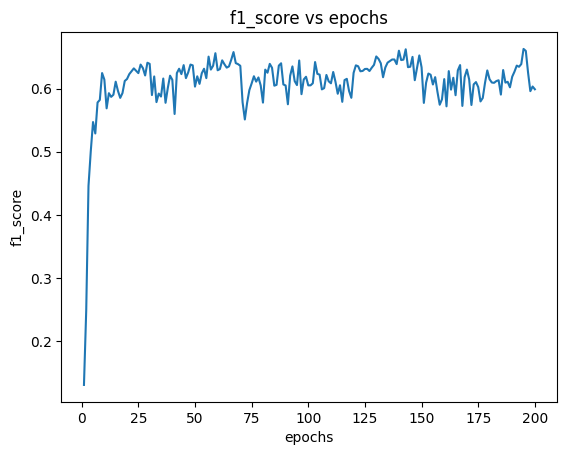

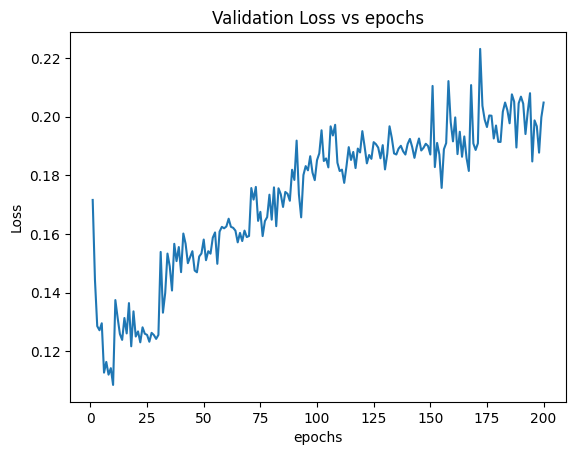

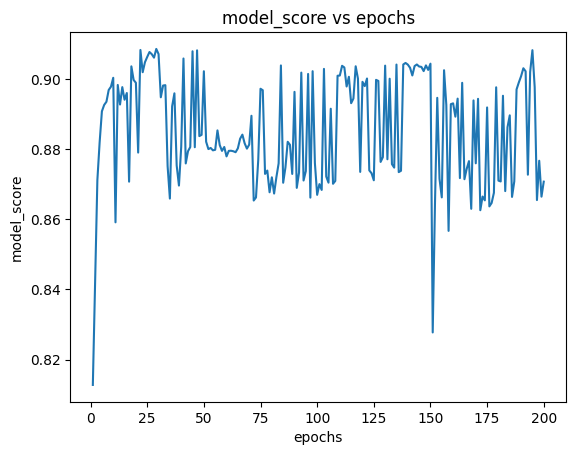

In [10]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

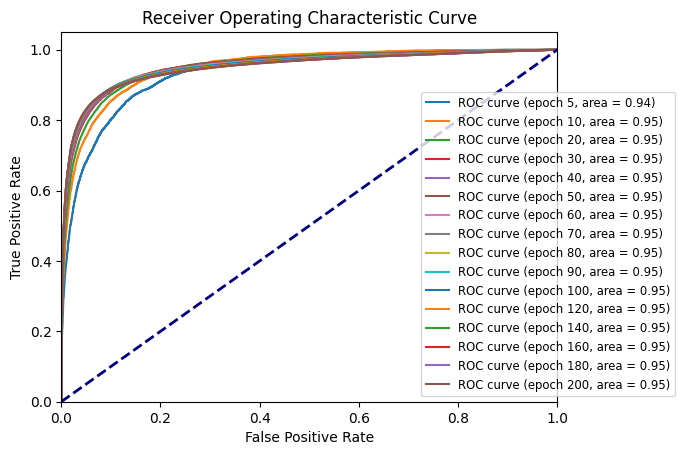

In [11]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)